# Cognitive Algorithms - Assignment 3 (30 points)
Cognitive Algorithms        
Winterterm 2017/2018      
Technische Universität Berlin     
Fachgebiet Machinelles Lernen 

**Due on November 30, 2017 10am via ISIS **
                    
After completing all tasks, run the whole notebook so that the content of each cell is properly displayed. Make sure that the code was ran and the entire output (e.g. figures) is printed. Print the notebook as a PDF file and again make sure that all lines are readable - use line breaks in the Python Code '\' if necessary. Points will be deducted, if code or content is not readable!                  
           
**Upload the PDF file that contains a copy of your notebook on ISIS.** 

# Part 2: Programming (17 points)
---

In this assignment you will compare the three linear classification algorithms that you encountered in the lecture - the Perceptron, the Nearest Centroid Classifier (NCC) and the Linear Discriminant Analysis (LDA). This comparision is done on a toy data set and on two different real data sets - the USPS data from the last assignment, and a Brain-Computer Interface (BCI) data set. 

Download the ```usps.mat``` and ```bcidata.mat``` data sets from the ISIS web site, if not done yet. Your task will be to implement LDA and use the provided code to analyse the data. 

The BCI data set consists of preprocessed EEG data $X \in\mathbb{R}^{5 \times 62 \times 5322}$ and stimulus labels $Y \in\mathbb R^{2 \times 5322}$ during a copy-spelling paradigm with a P300 speller. The data matrix $X$ contains 5 selected time windows of EEG activity at 62 electrodes after a visual stimulus was presented on the screen in front of the participant. If the first row of $Y$ is 1, the stimulus was a target stimulus, if the second row of $Y$ is 1, the stimulus was a non-target stimulus. The goal is to predict if the simulus was a target or not given the EEG.        
*Below you can find the provided code. Change the code only where indicated. See Part 2 Task A) for more information.*

In [1]:
import scipy as sp
import scipy.io as io
from scipy.linalg import inv
import pylab as pl
%matplotlib inline

In [2]:
def train_lda(X,Y):
    ''' Trains a linear discriminant analysis
    Definition:  w, b   = train_lda(X,Y)
    Input:       X       -  DxN array of N data points with D features
                 Y       -  1D array of length N of class labels {-1, 1}
    Output:      w       -  1D array of length D, weight vector  
                 b       -  bias term for linear classification                          
    '''
    # compute class mean vectors
    w1 = X[:,Y>0].mean(axis = 1)
    w2 = X[:,Y<0].mean(axis = 1)
    #compute within-class covariance matrices
    Sw = sp.cov(X[:,Y>0])+sp.cov(X[:,Y<0])
    #compute the normal vector w
    s1 = inv(Sw)
    w = s1.dot(w1-w2)
    #compute the threshold
    b = 0.5*w.T.dot(w1+w2) + sp.log(len(X[:,Y<1])/len(X[:,Y>1]))
    
    # hint: use the scipy/numpy function sp.cov
    return w,b
    
def load_usps_data(fname, digit=3):
    ''' Loads USPS (United State Postal Service) data from <fname> 
    Definition:  X, Y = load_usps_data(fname, digit = 3)
    Input:       fname   - string
                 digit   - optional, integer between 0 and 9, default is 3
    Output:      X       -  DxN array with N images with D pixels
                 Y       -  1D array of length N of class labels
                             (1 - picture displays <digit>, -1 - otherwise)                           
    '''
    # load the data
    data = io.loadmat(fname)
    # extract images and labels
    X = data['data_patterns']
    Y = data['data_labels']
    Y = Y[digit,:]
    return X, Y
    
    
def load_bci_data(fname):
    ''' Loads BCI data (one subject, copy-spelling experiment) from <fname> 
    Definition:  X, Y = load_bci_data(fname)
    Input:       fname   - string
    Output:      X       -  DxN array with N images with D pixels
                 Y       -  1D array of length N of class labels 
                            (1- target, -1 - non-target)                         
    '''
    # load the data1.93692527228
    data = io.loadmat(fname)
    # extract time-electrode features and labels
    X = data['X']
    Y = data['Y']
    # collapse the time-electrode dimensions
    X = sp.reshape(X,(X.shape[0]*X.shape[1],X.shape[2]))
    # transform the labels to (-1,1)
    Y = sp.sign((Y[0,:]>0) -.5)
    return X,Y

def train_perceptron(X,Y,iterations=200,eta=.1):
    ''' Trains a linear perceptron
    Definition:  w, b, acc  = train_perceptron(X,Y,iterations=200,eta=.1)
    Input:       X       -  DxN array of N data points with D features
                 Y       -  1D array of length N of class labels {-1, 1}
                 iter    -  optional, number of iterations, default 200
                 eta     -  optional, learning rate, default 0.1
    Output:      w       -  1D array of length D, weight vector 
                 b       -  bias term for linear classification                          
    '''
    #include the bias term by adding a row of ones to X 
    X = sp.concatenate((sp.ones((1,X.shape[1])), X))
    #initialize weight vector
    weights = sp.ones((X.shape[0]))/X.shape[0]
    for it in sp.arange(iterations):
        # indices of misclassified data
        wrong = (sp.sign(weights.dot(X)) != Y).nonzero()[0]
        if wrong.shape[0] > 0:
            # pick a random misclassified data point
            m = wrong[sp.random.randint(0, wrong.shape[0]-1)]
            #update weight vector (use variable learning rate (eta/(1.+it)) )
            weights = weights  + (eta/(1.+it)) * X[:, m] * Y[m]; 
            # compute accuracy
            wrong = (sp.sign(weights.dot(X)) != Y).nonzero()[0]
    b = -weights[0] 
    w = weights[1:]
    return w,b

def train_ncc(X,Y):
    ''' Trains a nearest centroid classifier
    Definition:  w, b   = train_ncc(X,Y)
    Input:       X       -  DxN array of N data points with D features
                 Y       -  1D array of length N of class labels {-1, 1}
    Output:      w       -  1D array of length D, weight vector  
                 b       -  bias term for linear classification                          
    '''
    #class means
    mupos = sp.mean(X[:,Y>0],axis=1)
    muneg = sp.mean(X[:,Y<0],axis=1)
    #weight vector and bias term
    w = mupos - muneg
    b = (w.dot(mupos) + w.dot(muneg))/2.
    return w,b
    
def plot_histogram(X, Y, w, b, cname):
    ''' Plots a histogram of classifier outputs (w^T X) for each class 
    Input:          X       -  DxN array of N data points with D features
                    Y       -  1D array of length N of class labels
                    w       -  1D array of length D, weight vector 
                    b       -  bias term for linear classification  
                    cname   - name of the classifier 
    '''
    pl.hist((w.dot(X[:,Y<0]), w.dot(X[:,Y>0])))
    pl.xlabel("w^T X")
    pl.title(cname + ' ' + str(100*sp.sum(sp.sign(w.dot(X)-b)==Y)/X.shape[1]) + "%")   
     
def compare_classifiers_toy():
    '''
    Compares 3 different linear classifiers (Nearest-Centroid, Linear Discriminant Analysis, 
    Perceptron) on 2 dimensional toy data
    '''
    #generate 2D data
    N =500
    cov = sp.array([[5, 0], [0, 0.5]])
    x1 = sp.random.multivariate_normal([-0.5, -0.5], cov, N) 
    x2 = sp.random.multivariate_normal([2.5, 0.5], cov, N) 
    X = sp.vstack((x1, x2)).transpose()
    Y = sp.hstack((sp.ones((N)), -1*sp.ones((N))))
    
    #train NCC, LDA and Perceptron
    w_ncc,b_ncc = train_ncc(X,Y)
    w_lda,b_lda = train_lda(X,Y)
    w_per,b_per = train_perceptron(X,Y)
       
    #plot result
    pl.figure()
    b_ncc = 10*b_ncc / sp.linalg.norm(w_ncc)
    b_lda = 10*b_lda / sp.linalg.norm(w_lda)
    b_per = 10*b_per / sp.linalg.norm(w_per)
    w_lda = 10*w_lda / sp.linalg.norm(w_lda)
    w_ncc = 10*w_ncc / sp.linalg.norm(w_ncc)
    w_per = 10*w_per / sp.linalg.norm(w_per)
    pl.plot([-w_lda[1], w_lda[1]], [w_lda[0]+b_lda/w_lda[1], -w_lda[0]+b_lda/w_lda[1]], 
        color = 'k', label='LDA: Acc ' + str(100*sp.sum(sp.sign(w_lda.dot(X)-b_lda)==Y)/X.shape[1]) + "%")
    pl.plot([-w_ncc[1], w_ncc[1]], [w_ncc[0]+b_ncc/w_ncc[1], -w_ncc[0]+b_ncc/w_ncc[1]], 
        color = 'r', linestyle = '--', label='NCC: Acc ' + str(100*sp.sum(sp.sign(w_ncc.dot(X)-b_ncc)==Y)/X.shape[1]) + "%")
    pl.plot([-w_per[1], w_per[1]], [w_per[0]+b_per/w_per[1], -w_per[0]+b_per/w_per[1]], 
        color = 'g', linestyle = ':', label='PER: Acc ' + str(100*sp.sum(sp.sign(w_per.dot(X)-b_per)==Y)/X.shape[1]) + "%")
    pl.plot(x1[:,0], x1[:,1], 'y+')
    pl.plot(x2[:,0], x2[:,1], 'b+')
    pl.axis('equal')
    pl.legend(loc=1)

def compare_classifiers(usps = True, digit = 3):
    '''
    Compares 3 different linear classifiers (Nearest-Centroid, Linear Discriminant Analysis, 
    Perceptron) on either USPS data (for usps=True) or on BCI data (for usps = False)
    '''
    if usps: #load usps data set
        X,Y = load_usps_data('usps.mat',digit)
        tit = 'USPS(' + str(digit) + ')'
    else: #load bci data set 
        X,Y = load_bci_data('bcidata.mat')
        tit = 'BCI'
    
    #Use crossvalidation to estimate the training and test accuracies
    acc_cv = sp.zeros((5, 6))
    (acc_cv[:,0],acc_cv[:,1]) = crossvalidate(X,Y,trainfun=train_ncc)
    (acc_cv[:,2],acc_cv[:,3]) = crossvalidate(X,Y,trainfun=train_lda)
    (acc_cv[:,4],acc_cv[:,5]) = crossvalidate(X,Y,trainfun=train_perceptron)
        
    #Plot the crossvalidation output
    pl.figure()
    ax1 = pl.subplot2grid((2,3), (0,0), colspan = 3)
    pl.bar(sp.array([1, 2, 3, 4, 5, 6]) - 0.4,  acc_cv.mean(0), width = 0.8,
        yerr =  acc_cv.std(0), ecolor = 'k', color = 'g')
    pl.xticks([1, 2, 3, 4, 5, 6], ['NCC tain', 'NCC test', 'LDA train', 'LDA test', 
        'PER train', 'PER test'])
    pl.xlim([0, 7])
    pl.ylim([0.5, 1])
    pl.ylabel('CV Accuracy')
    pl.title(tit + ' data set')

    #Train the classifiers and plot the output histograms
    w_ncc,b_ncc = train_ncc(X,Y)
    w_lda,b_lda = train_lda(X,Y)
    w_per,b_per= train_perceptron(X,Y)
    
    ax2 = pl.subplot2grid((2,3), (1,0))
    plot_histogram(X, Y, w_ncc, b_ncc, 'NCC')
    ax3 = pl.subplot2grid((2,3), (1,1))
    plot_histogram(X, Y, w_lda, b_lda, 'LDA')
    ax4 = pl.subplot2grid((2,3), (1,2))
    plot_histogram(X, Y, w_per, b_per, 'PER')

def crossvalidate(X,Y, f=5, trainfun=train_ncc):
    ''' 
    Test generalization performance of a linear classifier by crossvalidation
    Definition:     crossvalidate(X,Y, f=5, trainfun=train_ncc)
    Input:      X        -  DxN array of N data points with D features
                Y        -  1D array of length N of class labels
                f        - number of cross-validation folds
                trainfun - function for linear classification training
    Output:     acc_train - (f,) array of accuracies in test train folds
                acc_test  - (f,) array of accuracies in each test fold
    '''
    N = f*(X.shape[-1]//f)
    idx = sp.reshape(sp.arange(N),(f,N//f))
    acc_train = sp.zeros((f))
    acc_test = sp.zeros((f))
    
    for ifold in sp.arange(f):
        testidx = sp.zeros((f),dtype=bool)
        testidx[ifold] = 1
        test = idx[testidx,:].flatten()
        train = idx[~testidx,:].flatten()
        w,b = trainfun(X[:,train],Y[train])
        acc_train[ifold] = sp.sum(sp.sign(w.dot(X[:,train])-b)==Y[train])/sp.double(train.shape[0])
        acc_test[ifold] = sp.sum(sp.sign(w.dot(X[:,test])-b)==Y[test])/sp.double(test.shape[0])
    
    return acc_train,acc_test

**A) (7 points)** Implement a linear discriminant analysis (LDA) classifer by completing the function stub  ```train_lda```, that is, find a 
vector $\mathbf{w}$ such that  
$$\mathbf{w} = \underset{\mathbf{w}}{\text{argmax}} \; \frac{\mathbf{w}^T S_B \mathbf{w}}{\mathbf{w}^T S_{W} \mathbf{w}}$$
where $S_B$ denotes the 'between-class scatter' and $S_W$ denotes the 'within-class scatter'
\begin{eqnarray*}
S_B &= & (\mathbf w_+ - \mathbf w_{-})(\mathbf w_+ - \mathbf w_{-})^T \\
S_W &= & \frac{1}{N_{+}} \sum_{i=1}^{N_{+}}(\mathbf x_{+i} - \mathbf w_{+})  (\mathbf x_{+i} - \mathbf w_{+})^T + \frac{1}{N_{-}} \sum_{i=1}^{N_{-}}(\mathbf x_{-i} - \mathbf w_{-})  (\mathbf x_{-i} - \mathbf w_{-})^T
\end{eqnarray*}
and $\mathbf w_{+}$, $\mathbf w_{-}$ denote the respective class means. 

**B) (5 points)** Test your LDA implementation with the provided function ```compare_classifiers_toy```. It generates a 2D toy data set and plots the resulting separating hyperplanes for the three linear classification methods. Answer the following short questions: 
- Run the function several times - what do you notice for the Perceptron as compared to NCC or LDA? In one sentence, explain the behaviour of the perceptron. 
- Have a look in the code how the toy data is generated - is LDA optimal for this type of data? Why?
- How would you have to change the data generation such that NCC and LDA yield the same result? Why?


**[Your answers for B) here]**
- Percepton is the only one with fluctuating accuracy.
- Yes because x1 and x2 are generated based on the Gaussian distribution. Such a distribution is specified by its mean and covariance matrix 
- You have to use the Identety matrix as covariance matrix ([1, 0], [0, 1])

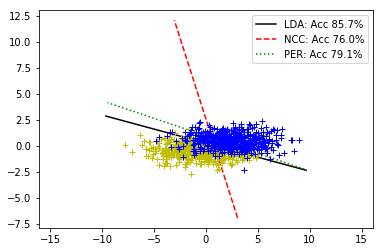

In [3]:
compare_classifiers_toy()


**C) (1 points)** Call ```compare_classifiers``` for a digit of your choice of the USPS data set, as well as for the BCI data. It plots the histogram of classifier outputs and the classification accuracies for the NCC, the LDA and the perceptron. Which algorithm (Nearest Centroid Classifier, Linear Discriminant Analysis or Perceptron) would you prefer for which task? Why?

**[Your answers for C) here]**
- USPS: NCC -> because the accurancy is similar at all three algorithms but the weight vector is much better with the NCC 
- BCI: LDA ->  accuracy is much better than NCC and perceptron


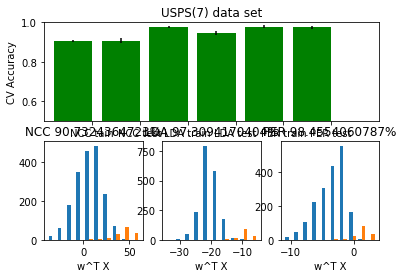

In [4]:
compare_classifiers(True,7)
#compare_classifiers(False)

**D) (4 points)** Briefly explain in your own words how crossvalidation is done. To do so, you can examine the function ```crossvalidate```. When we want to compare the performance of different classifiers, which values should we look at - the train or the test accuracies? Why?

**[Your answers for D) here]**
- you do cross-validation to see, how big the generalization error is. had the classifier learnt just the training data set or had he learnt the general task? to answer that you split your data set and use one part for training and the other part for testing. the train accuracies show how good the classifier learnt the data set and the test accuracies show how good the classifier learnt the task behind and that is what we are interested in the end.